# Teste de Conexão DuckDB + MinIO + dbt

Este notebook testa a integração do ambiente de notebooks com:
- DuckDB (banco de dados analítico)
- MinIO (armazenamento S3-compatible)
- dbt (transformações)

As queries são baseadas em `scripts/example_queries.py`


## 1. Importar Bibliotecas


In [3]:
import duckdb
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Configurar visualização
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline


## 2. Configurar Conexão DuckDB


In [4]:
# Caminho do banco de dados (compartilhado com outros serviços)
db_path = "/app/lakehouse/lakehouse.duckdb"
os.makedirs(os.path.dirname(db_path), exist_ok=True)

# Conectar ao DuckDB
con = duckdb.connect(db_path)
print(f"✓ Conectado ao DuckDB: {db_path}")


✓ Conectado ao DuckDB: /app/lakehouse/lakehouse.duckdb


## 3. Configurar Conexão S3 (MinIO)


In [5]:
# Obter variáveis de ambiente
minio_endpoint = os.getenv('MINIO_ENDPOINT', 'minio:9000')
minio_access_key = os.getenv('MINIO_ACCESS_KEY', 'admin')
minio_secret_key = os.getenv('MINIO_SECRET_KEY', 'minioadmin123')
minio_bucket = os.getenv('MINIO_BUCKET', 'lakehouse')

print(f"Configurando conexão S3 (MinIO)...")
print(f"  Endpoint: {minio_endpoint}")
print(f"  Bucket: {minio_bucket}")

# Configurar S3 no DuckDB
con.execute(f"""
    INSTALL httpfs;
    LOAD httpfs;
    INSTALL iceberg;
    LOAD iceberg;
    SET s3_endpoint='{minio_endpoint}';
    SET s3_access_key_id='{minio_access_key}';
    SET s3_secret_access_key='{minio_secret_key}';
    SET s3_use_ssl=false;
    SET s3_url_style='path';
""")

print(f"✓ Conexão S3 configurada: s3://{minio_bucket}/")


Configurando conexão S3 (MinIO)...
  Endpoint: minio:9000
  Bucket: lakehouse
✓ Conexão S3 configurada: s3://lakehouse/


## 4. Verificar Tabelas Disponíveis


In [6]:
# Listar tabelas
tables = con.execute("SHOW TABLES").fetchdf()
print("Tabelas disponíveis:")
display(tables)

# Verificar se a tabela principal existe
try:
    count = con.execute("SELECT COUNT(*) FROM vendas_iceberg").fetchone()[0]
    print(f"\n✓ Tabela 'vendas_iceberg' encontrada com {count:,} registros")
except Exception as e:
    print(f"\n⚠ Tabela 'vendas_iceberg' não encontrada: {e}")
    print("Execute primeiro o script init_lakehouse.py")


Tabelas disponíveis:


,name
0,dim_clientes
1,dim_produtos
2,fct_vendas
3,mart_vendas_mensal
4,stg_vendas
5,vendas_enriquecidas
6,vendas_iceberg



✓ Tabela 'vendas_iceberg' encontrada com 60,000 registros


## 5. Query 1: Receita por Categoria

Baseada em `query_1_revenue_by_category` do `example_queries.py`


Receita por Categoria:


,categoria,total_vendas,receita_total,ticket_medio,unidades_vendidas
0,Eletrônicos,10884,66617915.04,6120.719868,32664.0
1,Componentes,7332,28683700.44,3912.124992,21768.0
2,Periféricos,13764,12006091.20,872.282127,41508.0
3,Armazenamento,3696,5176683.12,1400.617727,11052.0


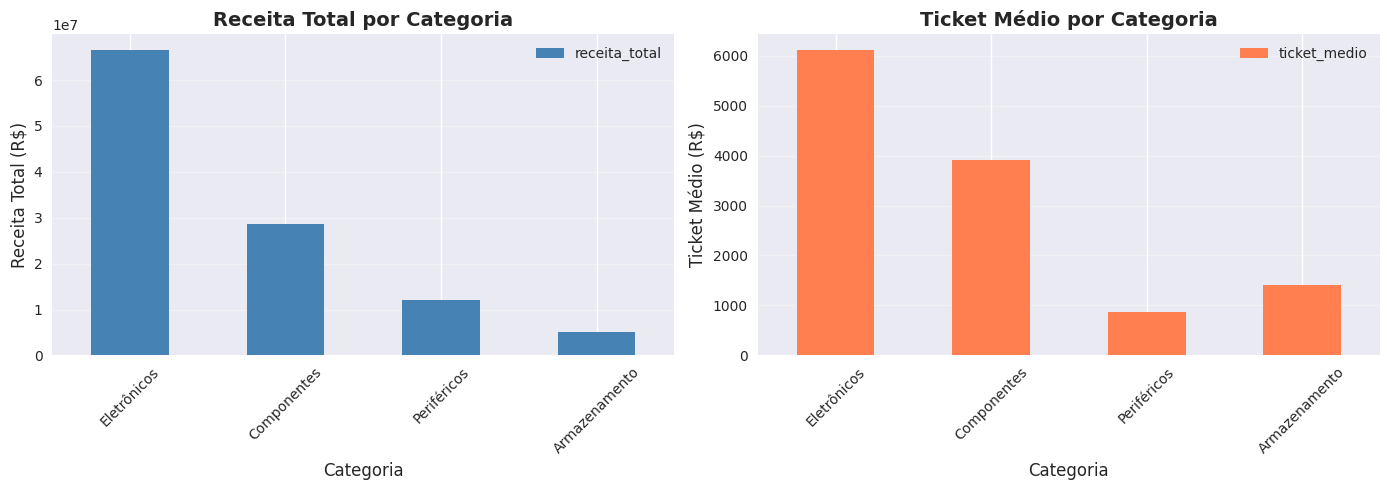

In [7]:
sql = """
SELECT 
    categoria,
    COUNT(*) as total_vendas,
    SUM(valor_final) as receita_total,
    AVG(valor_final) as ticket_medio,
    SUM(quantidade) as unidades_vendidas
FROM vendas_iceberg
WHERE status = 'Concluída'
GROUP BY categoria
ORDER BY receita_total DESC;
"""

df_revenue = con.execute(sql).fetchdf()
print("Receita por Categoria:")
display(df_revenue)

# Visualização
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras - Receita Total
df_revenue.plot(x='categoria', y='receita_total', kind='bar', ax=ax1, color='steelblue')
ax1.set_title('Receita Total por Categoria', fontsize=14, fontweight='bold')
ax1.set_xlabel('Categoria', fontsize=12)
ax1.set_ylabel('Receita Total (R$)', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# Gráfico de barras - Ticket Médio
df_revenue.plot(x='categoria', y='ticket_medio', kind='bar', ax=ax2, color='coral')
ax2.set_title('Ticket Médio por Categoria', fontsize=14, fontweight='bold')
ax2.set_xlabel('Categoria', fontsize=12)
ax2.set_ylabel('Ticket Médio (R$)', fontsize=12)
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


Tendência de Vendas Mensal:


,mes,total_vendas,receita_mensal,ticket_medio,clientes_unicos
0,2023-01-01,1500,4044067.80,2696.045200,125
1,2023-02-01,1572,4982054.76,3169.246031,131
2,2023-03-01,1740,5706322.08,3279.495448,145
3,2023-04-01,1428,5655265.80,3960.270168,119
4,2023-05-01,1632,5169752.28,3167.740368,135
5,2023-06-01,1680,5748604.68,3421.788500,140
6,2023-07-01,1548,4632897.00,2992.827519,128
7,2023-08-01,1536,4602053.88,2996.128828,128
8,2023-09-01,1464,5325060.00,3637.336066,122
9,2023-10-01,1500,4196978.40,2797.985600,124


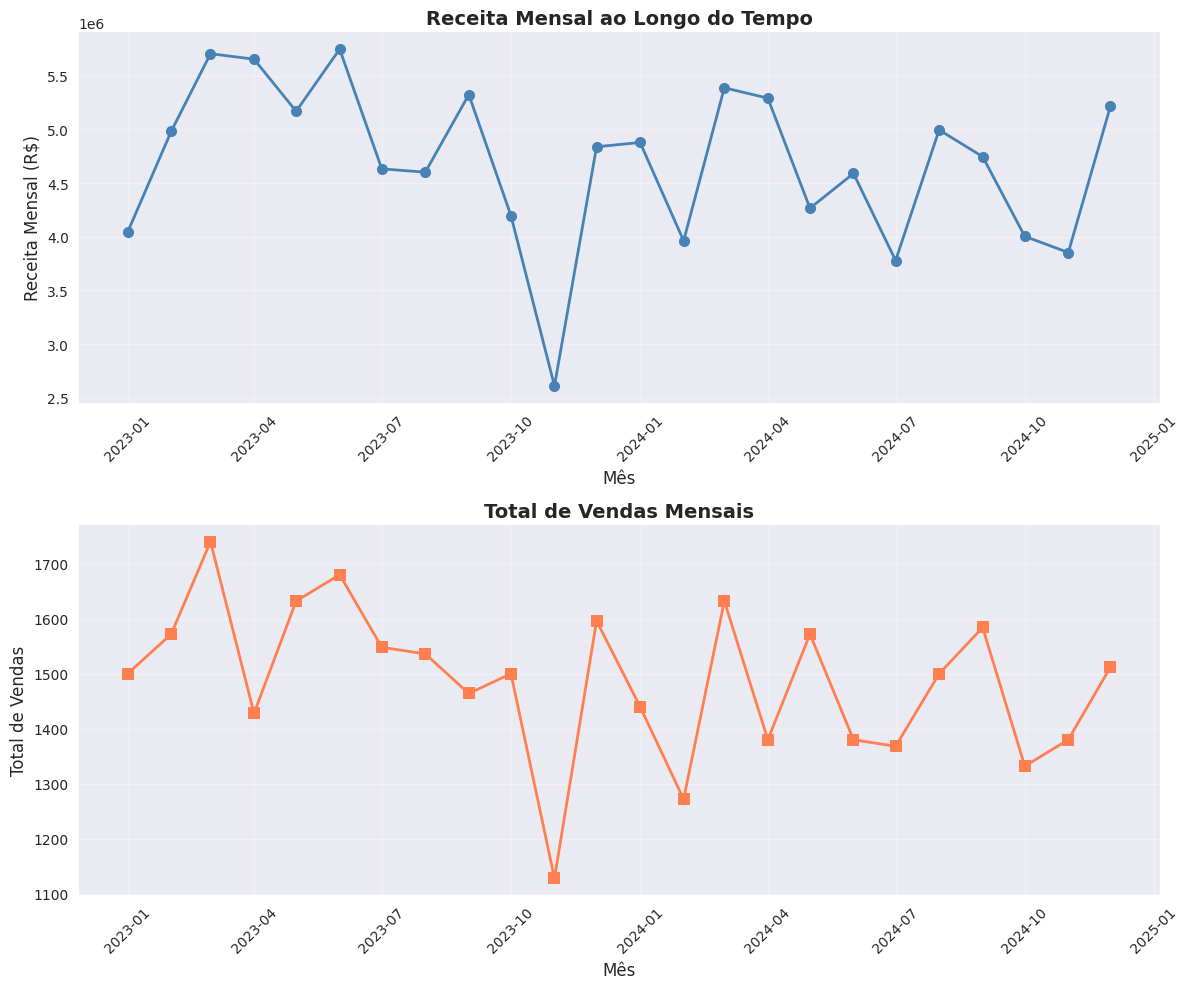

In [8]:
sql = """
SELECT 
    DATE_TRUNC('month', data_venda) as mes,
    COUNT(*) as total_vendas,
    SUM(valor_final) as receita_mensal,
    AVG(valor_final) as ticket_medio,
    COUNT(DISTINCT cliente_id) as clientes_unicos
FROM vendas_iceberg
WHERE status = 'Concluída'
GROUP BY DATE_TRUNC('month', data_venda)
ORDER BY mes;
"""

df_trend = con.execute(sql).fetchdf()
df_trend['mes'] = pd.to_datetime(df_trend['mes'])

print("Tendência de Vendas Mensal:")
display(df_trend)

# Visualização
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Gráfico de linha - Receita Mensal
ax1.plot(df_trend['mes'], df_trend['receita_mensal'], marker='o', linewidth=2, markersize=8, color='steelblue')
ax1.set_title('Receita Mensal ao Longo do Tempo', fontsize=14, fontweight='bold')
ax1.set_xlabel('Mês', fontsize=12)
ax1.set_ylabel('Receita Mensal (R$)', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Gráfico de linha - Total de Vendas
ax2.plot(df_trend['mes'], df_trend['total_vendas'], marker='s', linewidth=2, markersize=8, color='coral')
ax2.set_title('Total de Vendas Mensais', fontsize=14, fontweight='bold')
ax2.set_xlabel('Mês', fontsize=12)
ax2.set_ylabel('Total de Vendas', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## 7. Query 3: Top 10 Clientes

Baseada em `query_3_top_customers` do `example_queries.py`


Top 10 Clientes por Valor Total Gasto:


,cliente_id,cliente_nome,cliente_cidade,cliente_estado,total_compras,valor_total_gasto,ticket_medio
0,6355,Júlia Pereira,Rodrigues do Sul,PI,12,229471.20,19122.60
1,7519,Sra. Alexia Moura,Lopes Paulista,PA,12,222452.28,18537.69
2,9001,Raquel Correia,da Luz,PB,12,220364.64,18363.72
3,1723,Gustavo Almeida,Mendes,RJ,12,220296.84,18358.07
4,7618,Kaique Porto,Lopes de Correia,MS,12,217162.56,18096.88
5,4826,Bryan da Cruz,Moura,MG,12,216975.48,18081.29
6,9750,Ryan da Rocha,Nunes,RJ,12,215318.64,17943.22
7,6138,João Felipe Silva,Ferreira,CE,12,213325.56,17777.13
8,9827,Vitor Hugo Pires,da Cruz de Teixeira,ES,12,212943.12,17745.26
9,8424,Igor Oliveira,Porto,PA,12,212533.20,17711.10


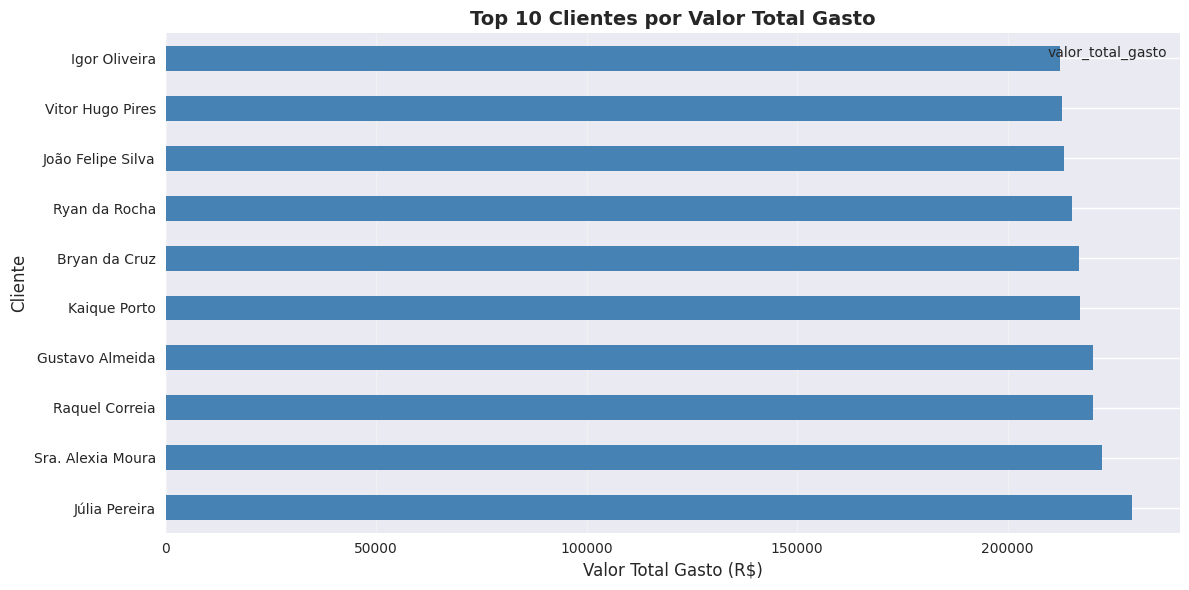

In [9]:
sql = """
SELECT 
    cliente_id,
    cliente_nome,
    cliente_cidade,
    cliente_estado,
    COUNT(*) as total_compras,
    SUM(valor_final) as valor_total_gasto,
    AVG(valor_final) as ticket_medio
FROM vendas_iceberg
WHERE status = 'Concluída'
GROUP BY cliente_id, cliente_nome, cliente_cidade, cliente_estado
ORDER BY valor_total_gasto DESC
LIMIT 10;
"""

df_top_customers = con.execute(sql).fetchdf()
print("Top 10 Clientes por Valor Total Gasto:")
display(df_top_customers)

# Visualização
fig, ax = plt.subplots(figsize=(12, 6))
df_top_customers.plot(x='cliente_nome', y='valor_total_gasto', kind='barh', ax=ax, color='steelblue')
ax.set_title('Top 10 Clientes por Valor Total Gasto', fontsize=14, fontweight='bold')
ax.set_xlabel('Valor Total Gasto (R$)', fontsize=12)
ax.set_ylabel('Cliente', fontsize=12)
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


## 8. Verificar Tabelas do dbt

Se o dbt foi executado, podemos consultar as tabelas transformadas.


In [10]:
# Verificar se existem tabelas do dbt
try:
    # Tabelas do dbt geralmente seguem o padrão: dim_*, fct_*, mart_*
    dbt_tables = con.execute("""
        SELECT table_name 
        FROM information_schema.tables 
        WHERE table_schema = 'main'
        AND (table_name LIKE 'dim_%' OR table_name LIKE 'fct_%' OR table_name LIKE 'mart_%')
        ORDER BY table_name
    """).fetchdf()
    
    if len(dbt_tables) > 0:
        print("✓ Tabelas do dbt encontradas:")
        display(dbt_tables)
        
        # Exemplo: consultar uma tabela do dbt
        if 'mart_vendas_mensal' in dbt_tables['table_name'].values:
            print("\nExemplo: Consultando mart_vendas_mensal do dbt:")
            df_mart = con.execute("SELECT * FROM mart_vendas_mensal LIMIT 10").fetchdf()
            display(df_mart)
    else:
        print("⚠ Nenhuma tabela do dbt encontrada.")
        print("Execute o dbt run primeiro.")
except Exception as e:
    print(f"⚠ Erro ao verificar tabelas do dbt: {e}")


✓ Tabelas do dbt encontradas:


,table_name
0,dim_clientes
1,dim_produtos
2,fct_vendas
3,mart_vendas_mensal



Exemplo: Consultando mart_vendas_mensal do dbt:


,mes,ano,mes_numero,total_vendas,clientes_unicos,produtos_vendidos,receita_total,ticket_medio,unidades_vendidas,total_descontos,desconto_medio_percentual,receita_eletronicos,receita_perifericos,receita_componentes,receita_online,receita_loja,receita_mes_anterior,crescimento_percentual
0,2023-01-01,2023,1,1500,125,10,4044067.80,2696.045200,4188.0,280655.76,6.100400,1974739.68,514965.96,1315932.24,496522.08,857785.08,NaN,NaN
1,2023-02-01,2023,2,1572,131,10,4982054.76,3169.246031,4812.0,385111.68,6.803740,3217257.60,645381.60,846239.64,1063812.72,1004089.92,NaN,NaN
2,2023-03-01,2023,3,1740,145,10,5706322.08,3279.495448,5472.0,363806.76,6.178621,3356295.72,493069.32,1535859.72,1609066.20,1157295.00,NaN,NaN
3,2023-04-01,2023,4,1428,119,10,5655265.80,3960.270168,4284.0,380443.20,6.777983,3581385.48,369308.64,1503919.44,1191089.76,1375517.52,NaN,NaN
4,2023-05-01,2023,5,1632,135,10,5169752.28,3167.740368,4524.0,252114.24,6.304044,2744354.04,534859.92,1702870.08,1460530.56,1324736.52,NaN,NaN
5,2023-06-01,2023,6,1680,140,10,5748604.68,3421.788500,4728.0,484312.32,7.429214,3490874.28,530362.20,1592694.00,1227844.08,2080935.96,NaN,NaN
6,2023-07-01,2023,7,1548,128,10,4632897.00,2992.827519,4284.0,243955.56,6.652713,2998032.96,385008.12,1014852.00,1338726.84,1653238.68,NaN,NaN
7,2023-08-01,2023,8,1536,128,10,4602053.88,2996.128828,4896.0,328983.96,6.680469,2599926.96,488768.28,1102657.08,1072435.20,1070718.60,NaN,NaN
8,2023-09-01,2023,9,1464,122,10,5325060.00,3637.336066,4356.0,342643.68,7.304918,3249341.64,465811.56,1498402.68,1795992.96,1291799.52,NaN,NaN
9,2023-10-01,2023,10,1500,124,10,4196978.40,2797.985600,4932.0,305988.72,7.413200,2363577.00,654892.20,906833.88,854382.48,1301265.60,NaN,NaN


## 9. Estatísticas Gerais


In [11]:
sql = """
SELECT 
    COUNT(*) as total_vendas,
    SUM(valor_final) as receita_total,
    AVG(valor_final) as ticket_medio,
    MIN(data_venda) as primeira_venda,
    MAX(data_venda) as ultima_venda,
    COUNT(DISTINCT cliente_id) as clientes_unicos,
    COUNT(DISTINCT categoria) as categorias,
    COUNT(DISTINCT produto_id) as produtos_unicos
FROM vendas_iceberg
WHERE status = 'Concluída';
"""

df_stats = con.execute(sql).fetchdf()
print("Estatísticas Gerais:")
display(df_stats)

# Fechar conexão
con.close()
print("\n✓ Conexão DuckDB fechada.")


Estatísticas Gerais:


,total_vendas,receita_total,ticket_medio,primeira_venda,ultima_venda,clientes_unicos,categorias,produtos_unicos
0,35676,112484389.8,3152.942869,2023-01-01,2024-12-30,2517,4,10



✓ Conexão DuckDB fechada.


## Conclusão

✓ Notebook conectado com sucesso ao DuckDB
✓ Queries executadas com sucesso
✓ Visualizações geradas
✓ Integração com MinIO configurada
✓ Tabelas do dbt verificadas (se disponíveis)

O ambiente de notebooks está funcionando corretamente!
